In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import tree
from sklearn.tree import DecisionTreeRegressor
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

df = pd.read_csv(r'Data\Sport car price.csv')

In [2]:
# pd.set_option('display.max_rows', None)

In [3]:
#finding rows with null values
df[df.isna().any(axis=1)]

,Car Make,Car Model,Year,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD)
168,Rimac,C_Two,2022,NaN,1914,1696,1.9,"2,400,000"
171,Tesla,Model S Plaid,2021,NaN,1020,1050,1.98,"131,190"
222,Porsche,Taycan Turbo S,2021,NaN,750,774,2.6,"185,000"
247,Tesla,Model S Plaid,2022,NaN,1020,1050,1.9,"131,190"
387,Rimac,C_Two,2022,NaN,1888,1696,1.8,"2,400,000"
389,Tesla,Roadster,2022,NaN,10000+,0,1.9,"200,000"
642,Tesla,Model S Plaid,2021,Electric,1020,NaN,1.9,"139,990"
686,Rimac,C_Two,2022,NaN,1914,1696,1.85,"2,400,000"
697,Lotus,Evija,2022,NaN,1972,1254,2.5,"2,700,000"
752,Porsche,Taycan,2022,NaN,469,479,3.8,"79,900"


### Dropping rows where Engine Size and Torque is NaN.

In [4]:
df=df.dropna(subset=['Engine Size (L)','Torque (lb-ft)'])

# Splitting the original Dataframe into 2.
### One dataframe will contain all ICE (internal combustion engine) cars and the other dataframe will contain all Electric/Hybrid Cars
### For the DecisionTree Regressor model, we will use only ICE cars but with the Classifier model, we will concat the to dataframes together

In [5]:
dfElec = df.loc[df['Engine Size (L)'].str.contains('Electric|Hybrid')]
df = df.loc[~df['Engine Size (L)'].str.contains('Electric|Hybrid')]

### replaceing all commas, + and - for easier datatype conversions

In [6]:
df['Horsepower'] = df['Horsepower'].str.replace('[+,-,]', '')
df['Torque (lb-ft)'] = df['Torque (lb-ft)'].str.replace('[+,-,]', '')
df['Price (in USD)'] = df['Price (in USD)'].str.replace('[+,-,]', '')

In [7]:
df =df.drop(index=335) #torque value is missing. dropping that row

In [8]:
df.shape

(948, 8)

### Changing Datatypes of columns

In [9]:
df = df.astype({'Engine Size (L)':'float','Horsepower': 'int64', 'Torque (lb-ft)': 'int64', '0-60 MPH Time (seconds)': 'float', 'Price (in USD)': 'int64'})

In [10]:
df.dtypes #sanity check

Car Make                    object
Car Model                   object
Year                         int64
Engine Size (L)            float64
Horsepower                   int64
Torque (lb-ft)               int64
0-60 MPH Time (seconds)    float64
Price (in USD)               int64
dtype: object

### convert price to $1000s units

In [11]:
df['Price (in USD $1000)'] = df['Price (in USD)'] / 1000
df = df.drop(columns='Price (in USD)')

### initial data-analysis and visualizations

In [12]:
df[['Engine Size (L)', 'Horsepower', 'Torque (lb-ft)', '0-60 MPH Time (seconds)', 'Price (in USD $1000)']].describe()

,Engine Size (L),Horsepower,Torque (lb-ft),0-60 MPH Time (seconds),Price (in USD $1000)
count,948.000000,948.000000,948.000000,948.000000,948.000000
mean,4.395781,603.325949,519.694093,3.586920,342.768959
std,1.398801,382.482684,285.783466,0.724134,690.903793
min,0.000000,181.000000,151.000000,1.900000,25.000000
25%,3.500000,454.000000,398.000000,3.000000,70.471250
50%,4.000000,583.000000,505.000000,3.500000,121.750000
75%,5.200000,660.000000,590.000000,4.000000,240.250000
max,8.400000,10000.000000,7376.000000,6.500000,5200.000000


In [13]:
#Drop outlier of horsepower >2000, Torque >2000
indexAge = df[ (df['Horsepower'] > 2000) | (df['Torque (lb-ft)'] > 2000) ].index
df.drop(indexAge , inplace=True)

In [14]:
df.dtypes

Car Make                    object
Car Model                   object
Year                         int64
Engine Size (L)            float64
Horsepower                   int64
Torque (lb-ft)               int64
0-60 MPH Time (seconds)    float64
Price (in USD $1000)       float64
dtype: object

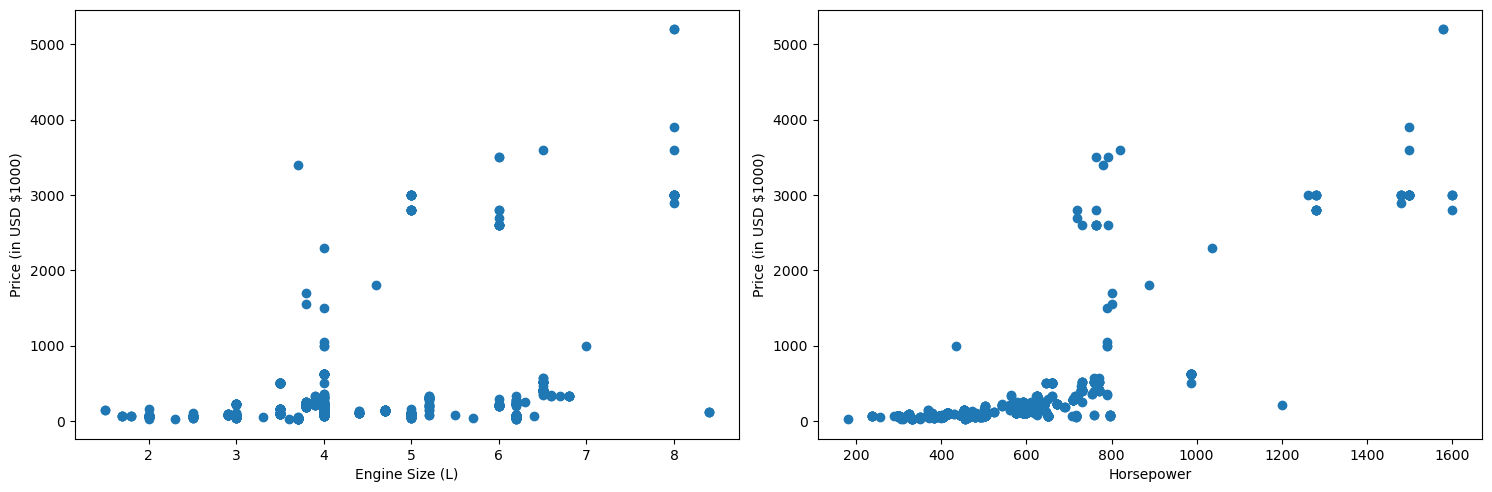

In [15]:
y = df['Price (in USD $1000)']
fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].scatter(df['Engine Size (L)'], y)
ax[0].set_xlabel('Engine Size (L)')
ax[0].set_ylabel('Price (in USD $1000)')
ax[1].scatter(df['Horsepower'], y)
ax[1].set_xlabel('Horsepower')
ax[1].set_ylabel('Price (in USD $1000)')

fig.tight_layout(pad=1)
plt.show()

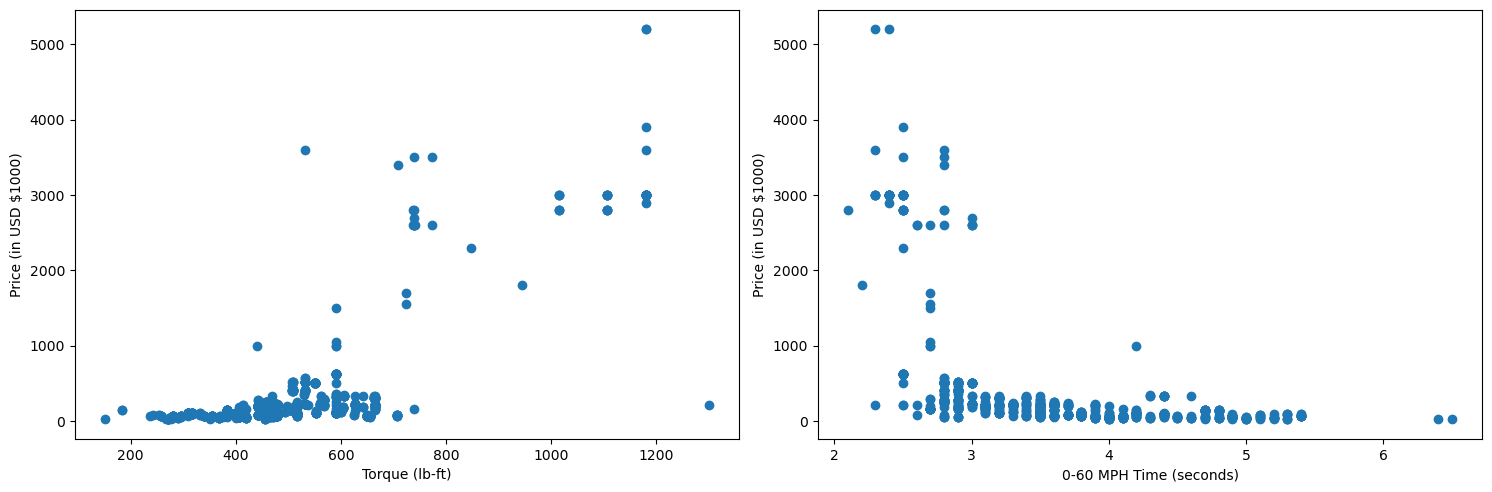

In [16]:
y = df['Price (in USD $1000)']
fig, ax = plt.subplots(1,2, figsize = (15,5))
ax[0].scatter(df['Torque (lb-ft)'], y)
ax[0].set_xlabel('Torque (lb-ft)')
ax[0].set_ylabel('Price (in USD $1000)')
ax[1].scatter(df['0-60 MPH Time (seconds)'], y)
ax[1].set_xlabel('0-60 MPH Time (seconds)')
ax[1].set_ylabel('Price (in USD $1000)')
fig.tight_layout(pad=1)
plt.show()

# Decision Tree ML
### Regression Model

For max depth of 3, the training R2score was 0.475 and test R2 score was 0.596


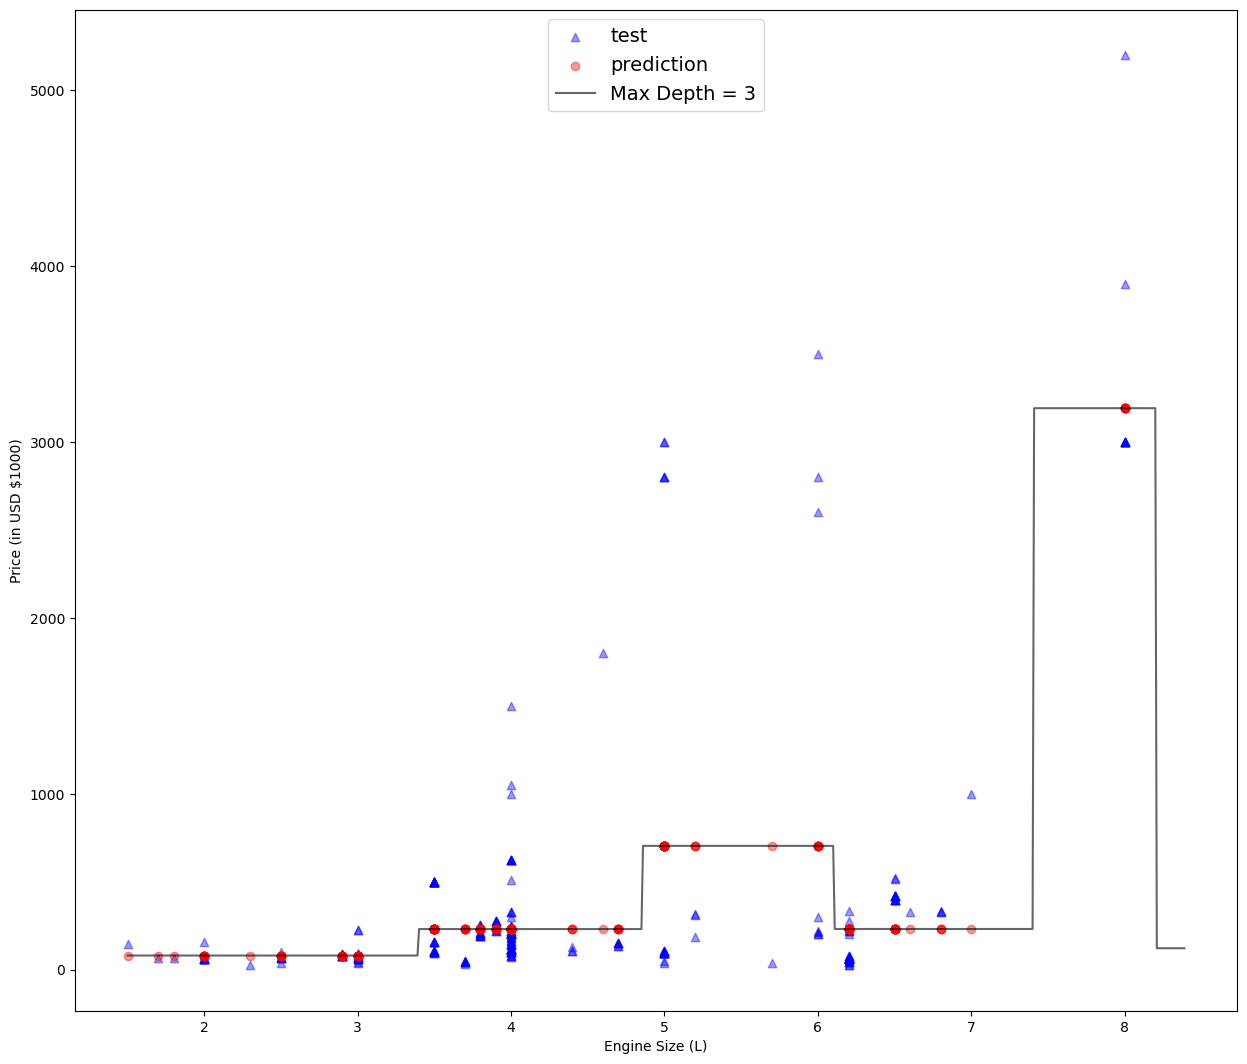

For max depth of 11, the training R2score was 0.542 and test R2 score was 0.624


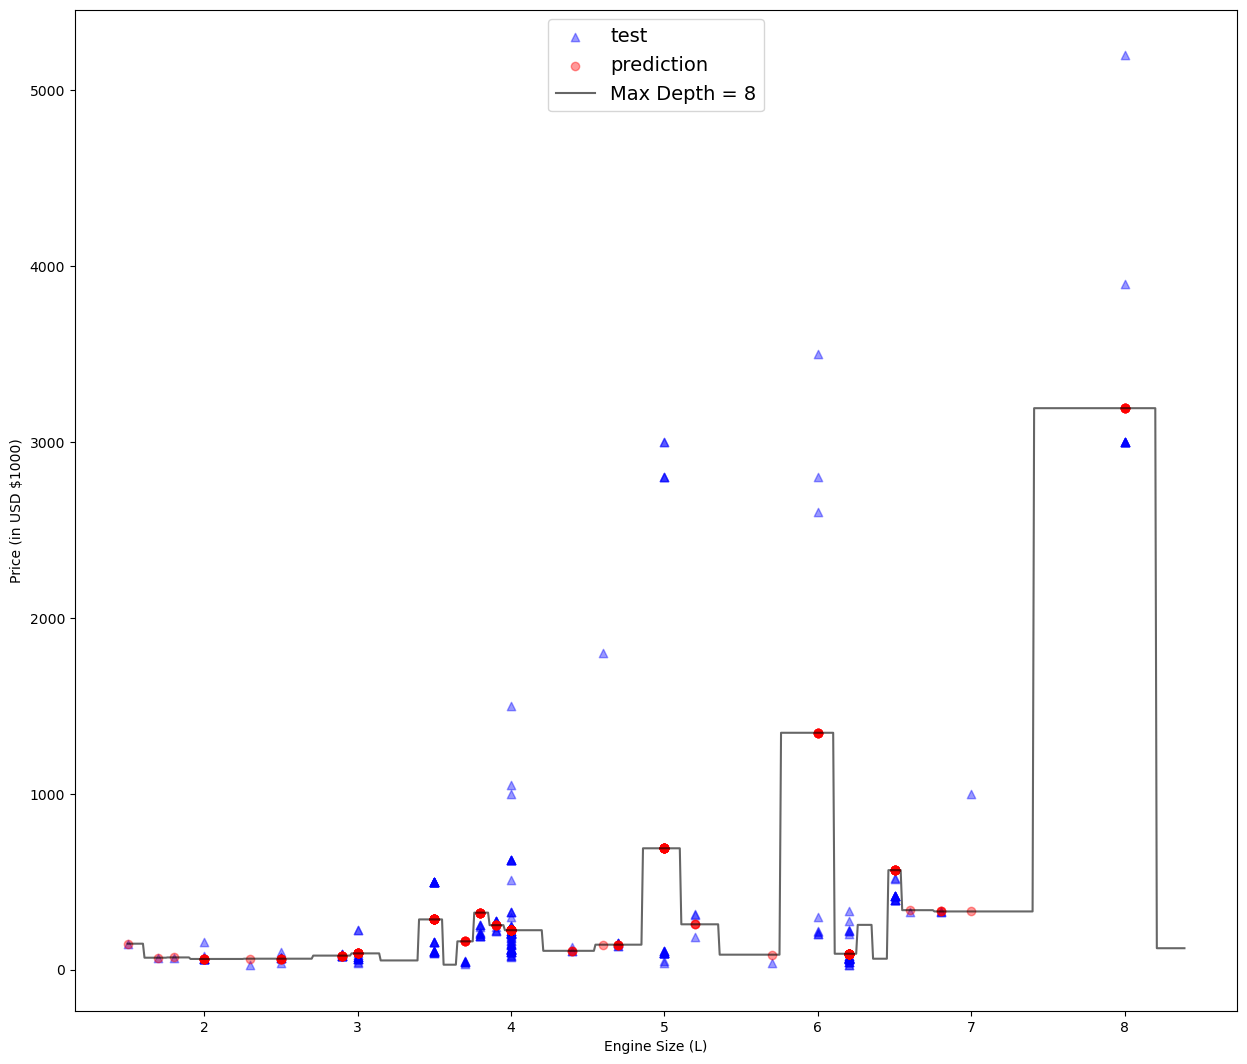

For max depth of 3, the training R2score was 0.802 and test R2 score was 0.789


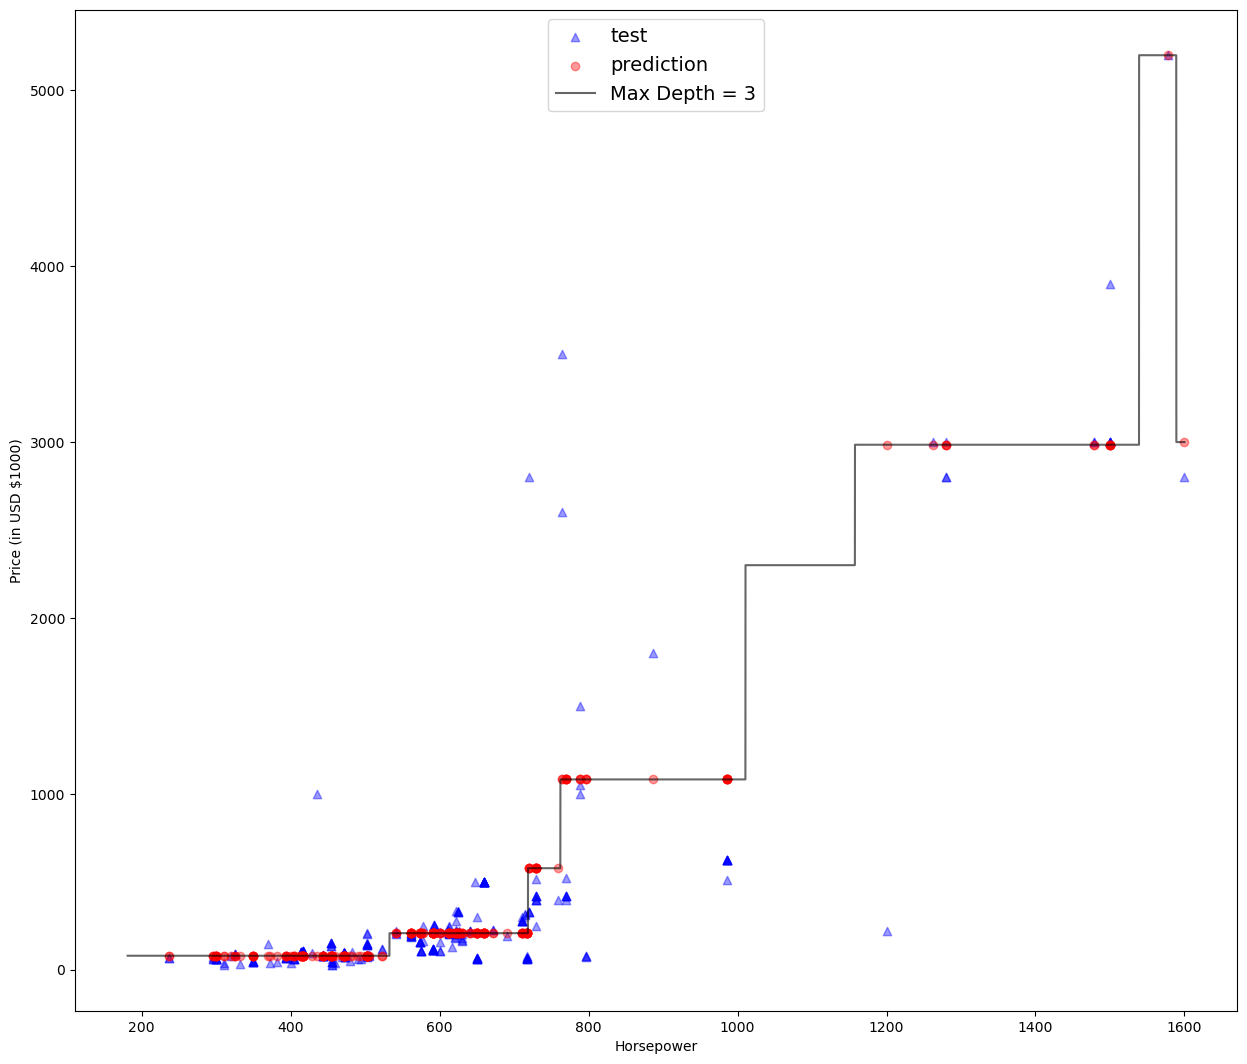

For max depth of 11, the training R2score was 0.968 and test R2 score was 0.876


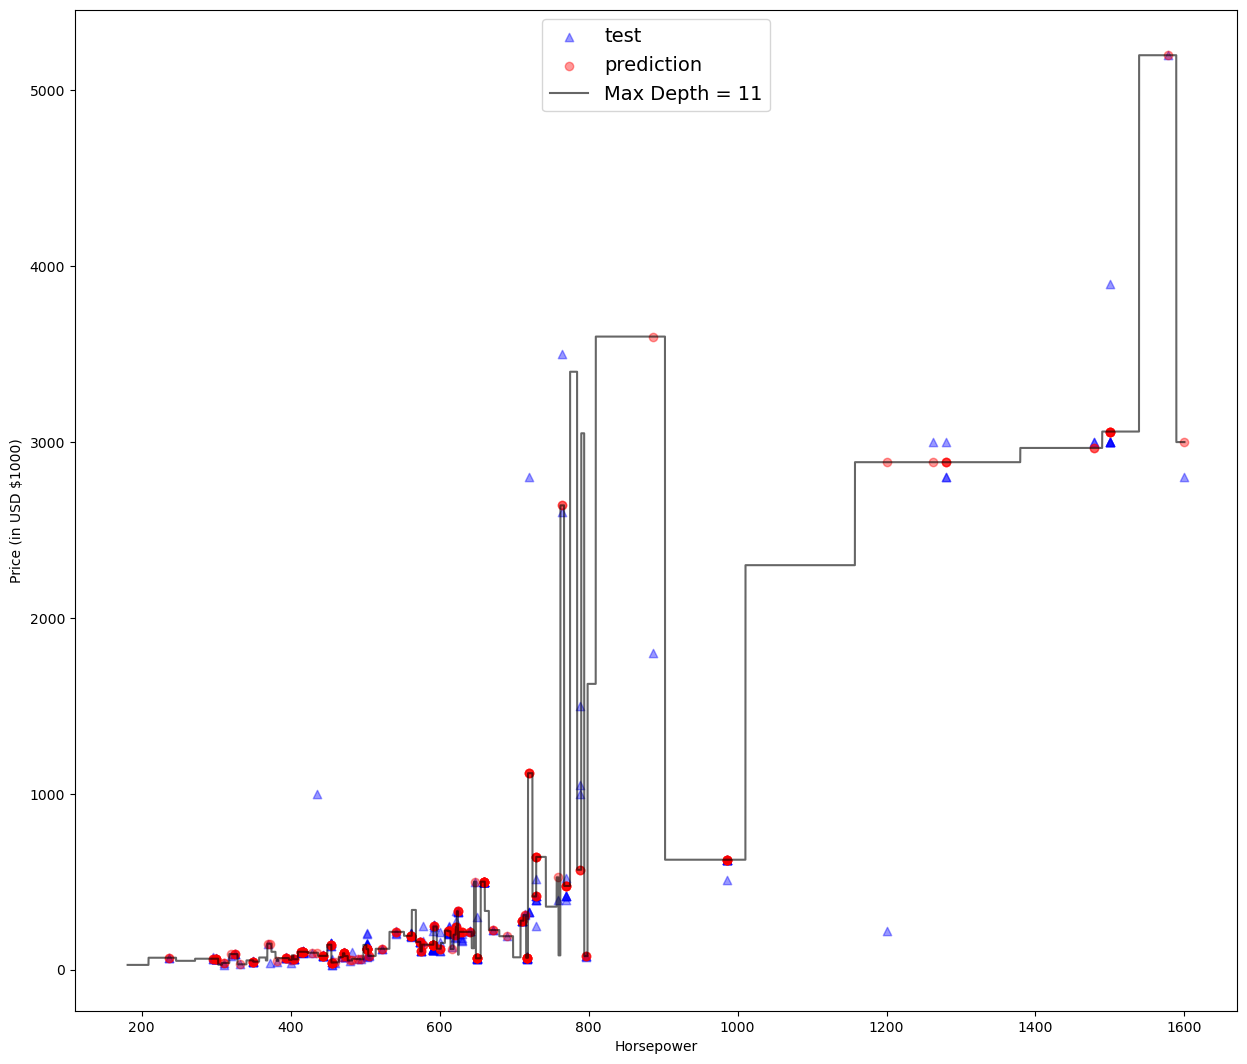

For max depth of 3, the training R2score was 0.911 and test R2 score was 0.821


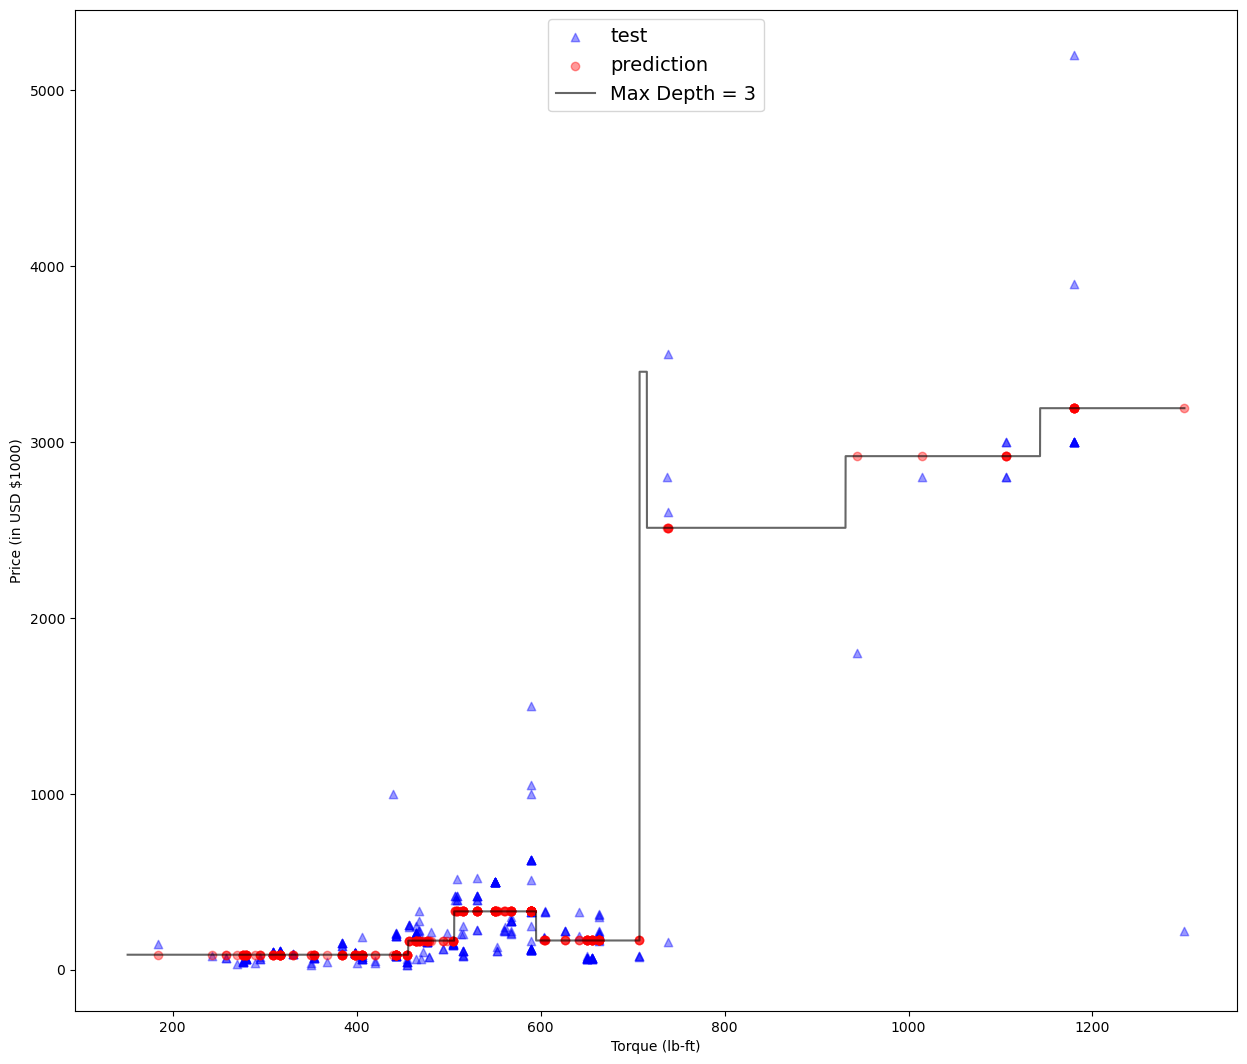

For max depth of 11, the training R2score was 0.936 and test R2 score was 0.828


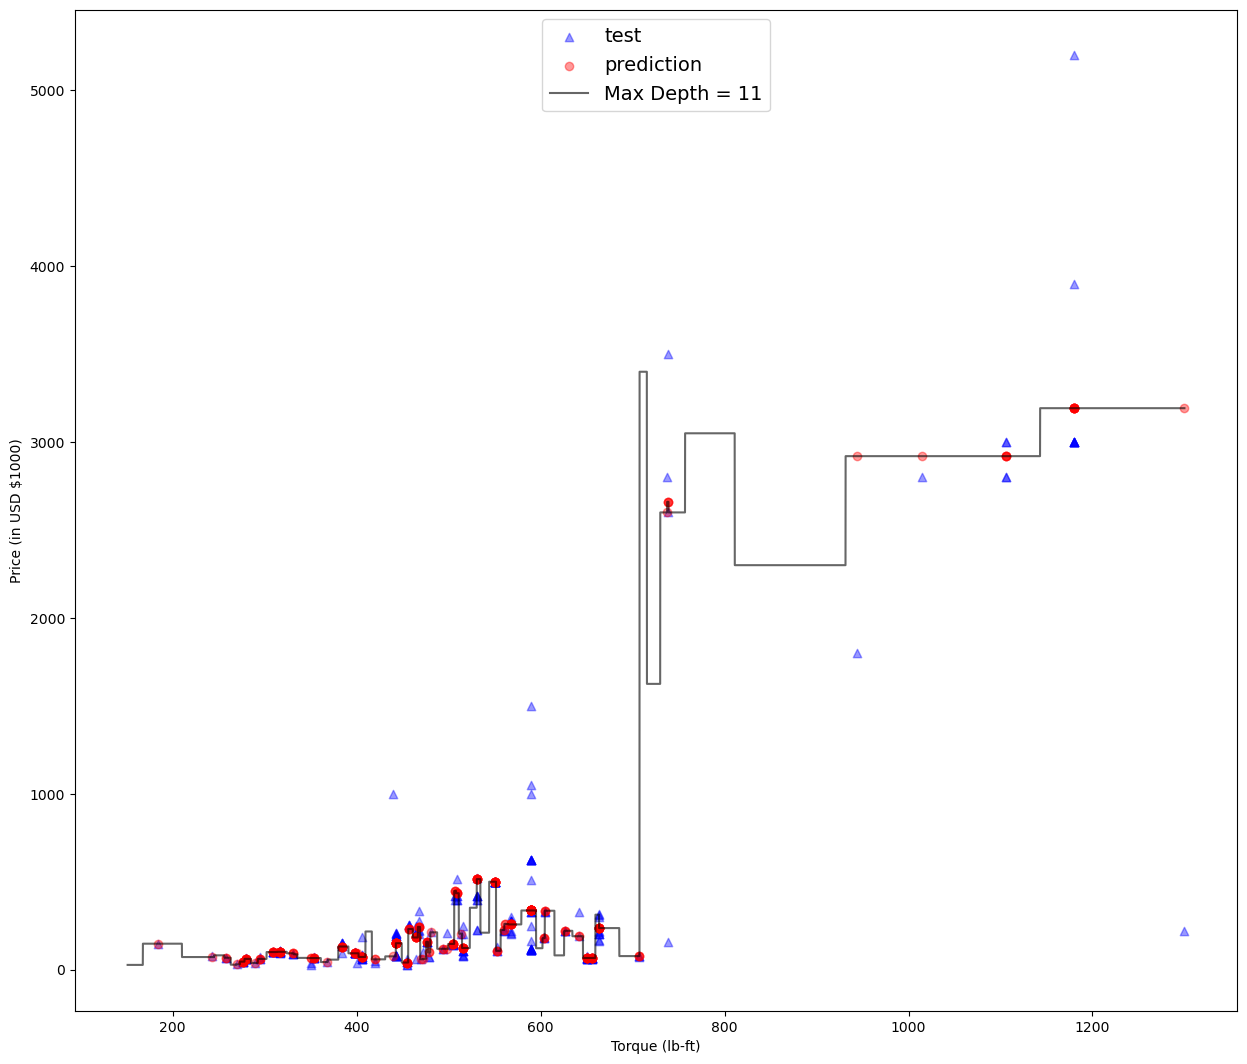

For max depth of 3, the training R2score was 0.647 and test R2 score was 0.605


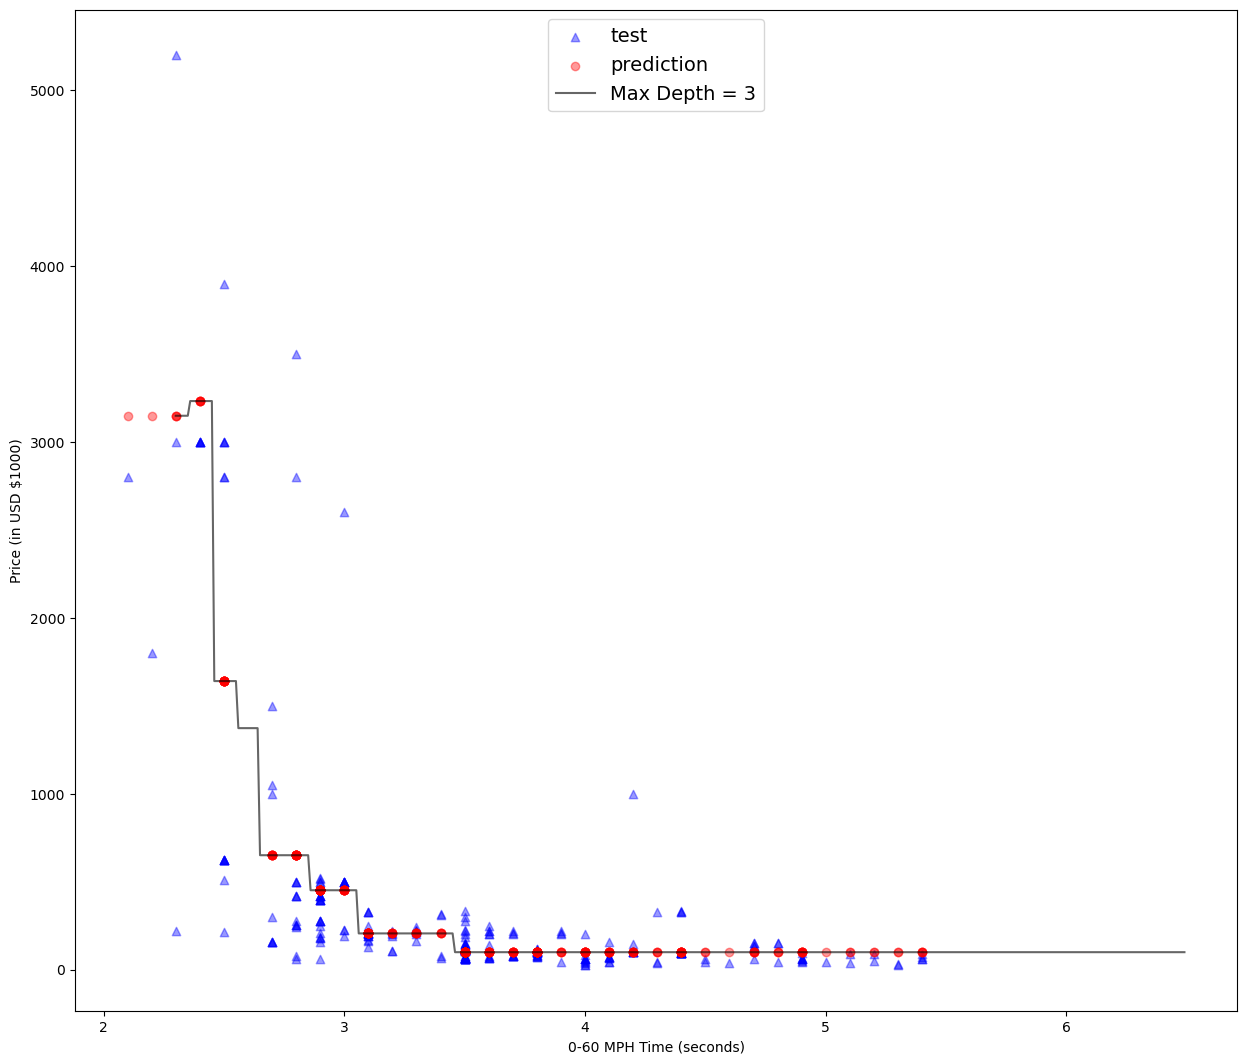

For max depth of 11, the training R2score was 0.653 and test R2 score was 0.61


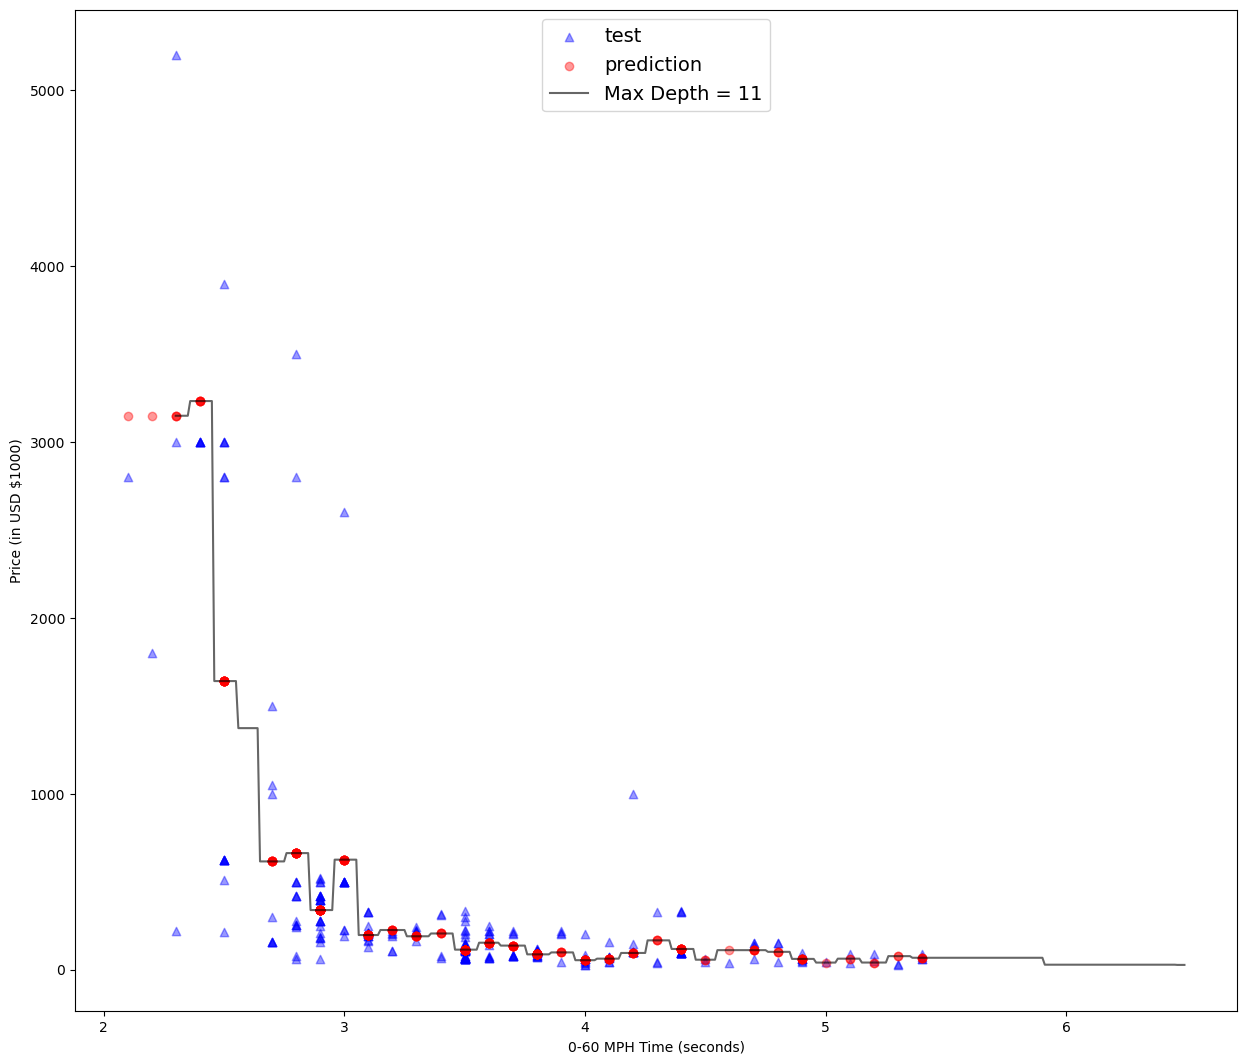

In [17]:
X = [] #list of features
for col in df.iloc[:,3:7]:
    X.append(df[[col]])
y= df['Price (in USD $1000)'] #target

for feature in X:
    X = feature  
    y = df['Price (in USD $1000)']
    for i in [3,11]:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=7)
        mod = DecisionTreeRegressor(max_depth=i, random_state=7)
        mod.fit(X_train, y_train)
        score = mod.score(X_test, y_test)
        print(f'For max depth of {i}, the training R2score was {round(mod.score(X_train, y_train),3)} and test R2 score was {round(mod.score(X_test, y_test),3)}')
        y_predict = mod.predict(X_test)
        plt.figure(figsize=(15, 13))
        plt.scatter(X_test, y_test, color = 'blue', marker='^', alpha=0.4)
        plt.scatter(X_test, y_predict, color = 'red', marker='o', alpha=0.4)
        plt.xlabel(X_test.columns[0])
        plt.ylabel('Price (in USD $1000)')
        X_grid = np.arange(min(X_train.values), max(X.values), 0.01)
        X_grid = X_grid.reshape((len(X_grid), 1))
        plt.plot(X_grid, mod.predict(X_grid), color='black', alpha= 0.6)
        plt.legend(['test', 'prediction', f'Max Depth = {mod.get_depth()}'], loc=9, fontsize=14)
        plt.show()

# Decision Tree to predict electric/hybrid/ice cars based on features???

In [18]:
dfElec['Horsepower'] = dfElec['Horsepower'].str.replace('[+,-,]', '')
dfElec['Torque (lb-ft)'] = dfElec['Torque (lb-ft)'].str.replace('[+,-,]', '')
dfElec['Price (in USD)'] = dfElec['Price (in USD)'].str.replace('[+,-,]', '')
dfElec['0-60 MPH Time (seconds)'] = dfElec['0-60 MPH Time (seconds)'].str.replace('< ', '')
dfElec = dfElec.astype({'Horsepower': 'int64', 'Torque (lb-ft)': 'int64', '0-60 MPH Time (seconds)': 'float', 'Price (in USD)': 'int64'})
indexAge = dfElec[ (df['Horsepower'] > 2000) | (dfElec['Torque (lb-ft)'] > 2000) ].index
dfElec.drop(indexAge , inplace=True)
dfElec['Price (in USD $1000)'] = dfElec['Price (in USD)'] / 1000
dfElec = dfElec.drop(columns='Price (in USD)')

In [19]:
dfElec.loc[dfElec['Engine Size (L)'].str.contains('Electric'), 'Engine Size (L)'] = 'Electric/Hybrid'
dfElec.loc[dfElec['Engine Size (L)'].str.contains('Hybrid'), 'Engine Size (L)'] = 'Electric/Hybrid'

In [20]:
#concat both dataframs
cars_df = pd.concat([df, dfElec])

In [21]:
cars_df['Engine Size (L)'] = cars_df['Engine Size (L)'].astype(str)

In [22]:
cars_df.loc[~cars_df['Engine Size (L)'].str.contains('Electric|Hybrid'), 'Engine Size (L)'] = 'ICE'
cars_df['Engine Size (L)'].value_counts()

ICE                947
Electric/Hybrid     46
Name: Engine Size (L), dtype: int64

### DecisionTree Classification to predict if a car is ICE or Electric/Hybrid.

In [23]:
y1 = cars_df['Engine Size (L)'] #whether it is ICE or electric/hybrid
X1 = cars_df.drop(['Engine Size (L)', 'Car Make', 'Car Model', 'Year'], axis=1) #features
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, random_state=7)

In [24]:
gini_models = []
print('Using the gini-criterion:')
for i in [3, 6, 9]:
    model_gini = DecisionTreeClassifier(random_state=7, criterion='gini', max_depth=i)
    model_gini.fit(X1_train, y1_train)
    print(f'For max depth of {i}, the training R2score was {round(model_gini.score(X1_train, y1_train),3)} and test R2 score was {round(model_gini.score(X1_test, y1_test),3)}')
    y_predict = model_gini.predict(X1_test)
    print(f'The accuracy for max depth of {i} was {round(accuracy_score(y1_test,y_predict),5)*100}%')
    gini_models.append(model_gini)

Using the gini-criterion:
For max depth of 3, the training R2score was 0.985 and test R2 score was 0.968
The accuracy for max depth of 3 was 96.787%
For max depth of 6, the training R2score was 0.993 and test R2 score was 0.98
The accuracy for max depth of 6 was 97.992%
For max depth of 9, the training R2score was 0.997 and test R2 score was 0.98
The accuracy for max depth of 9 was 97.992%


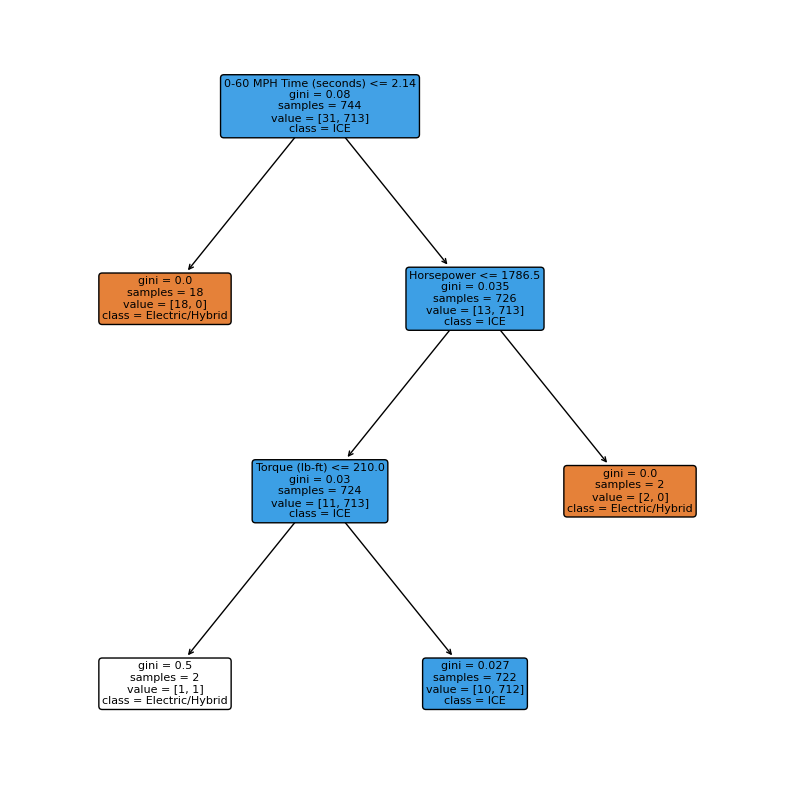

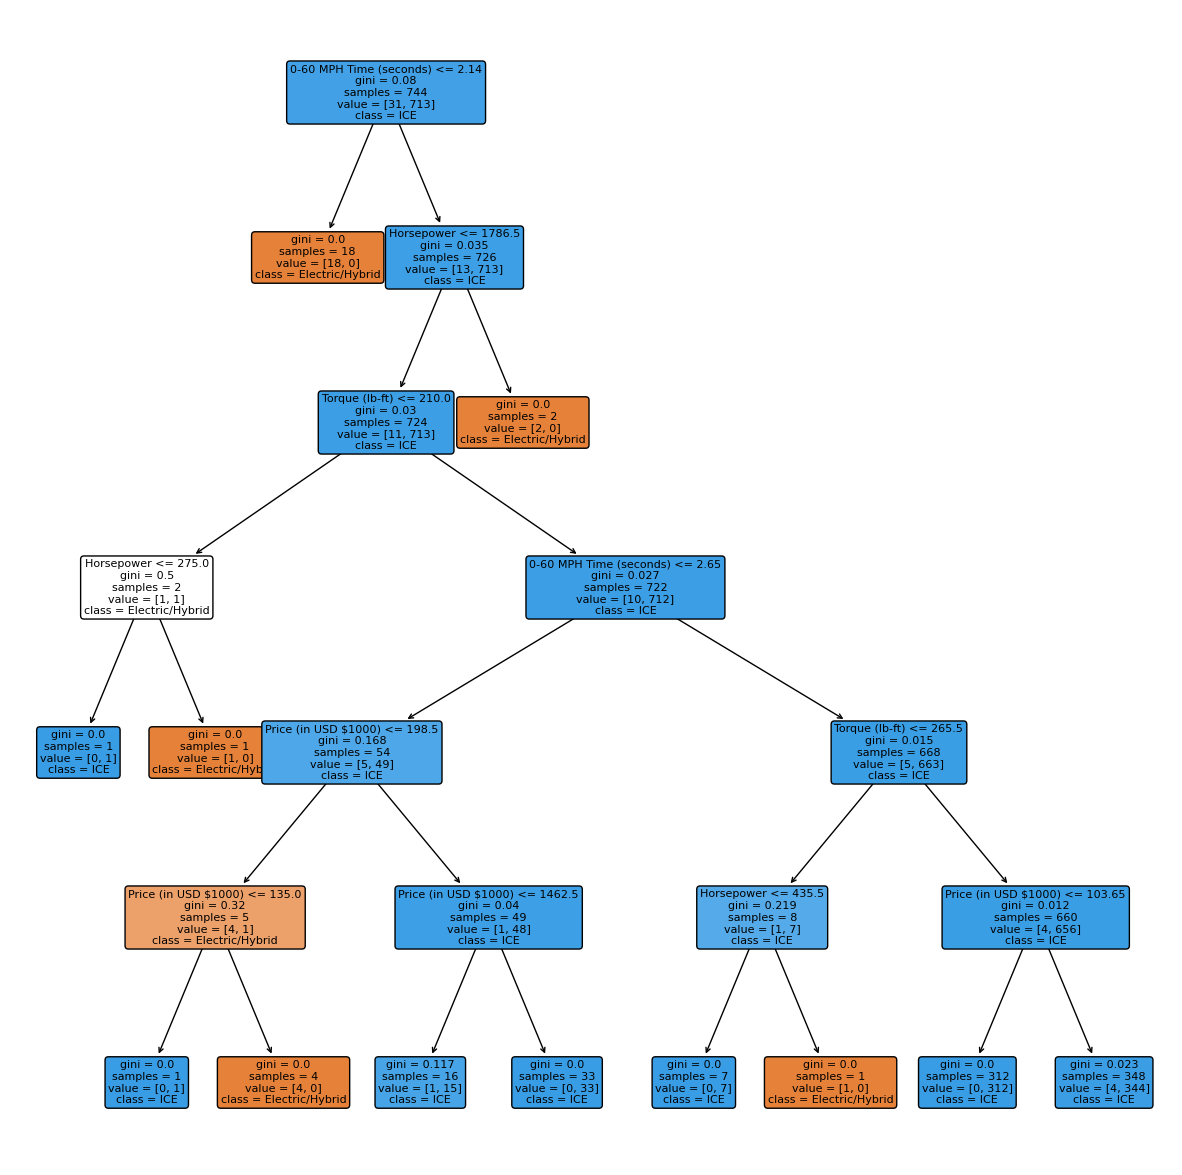

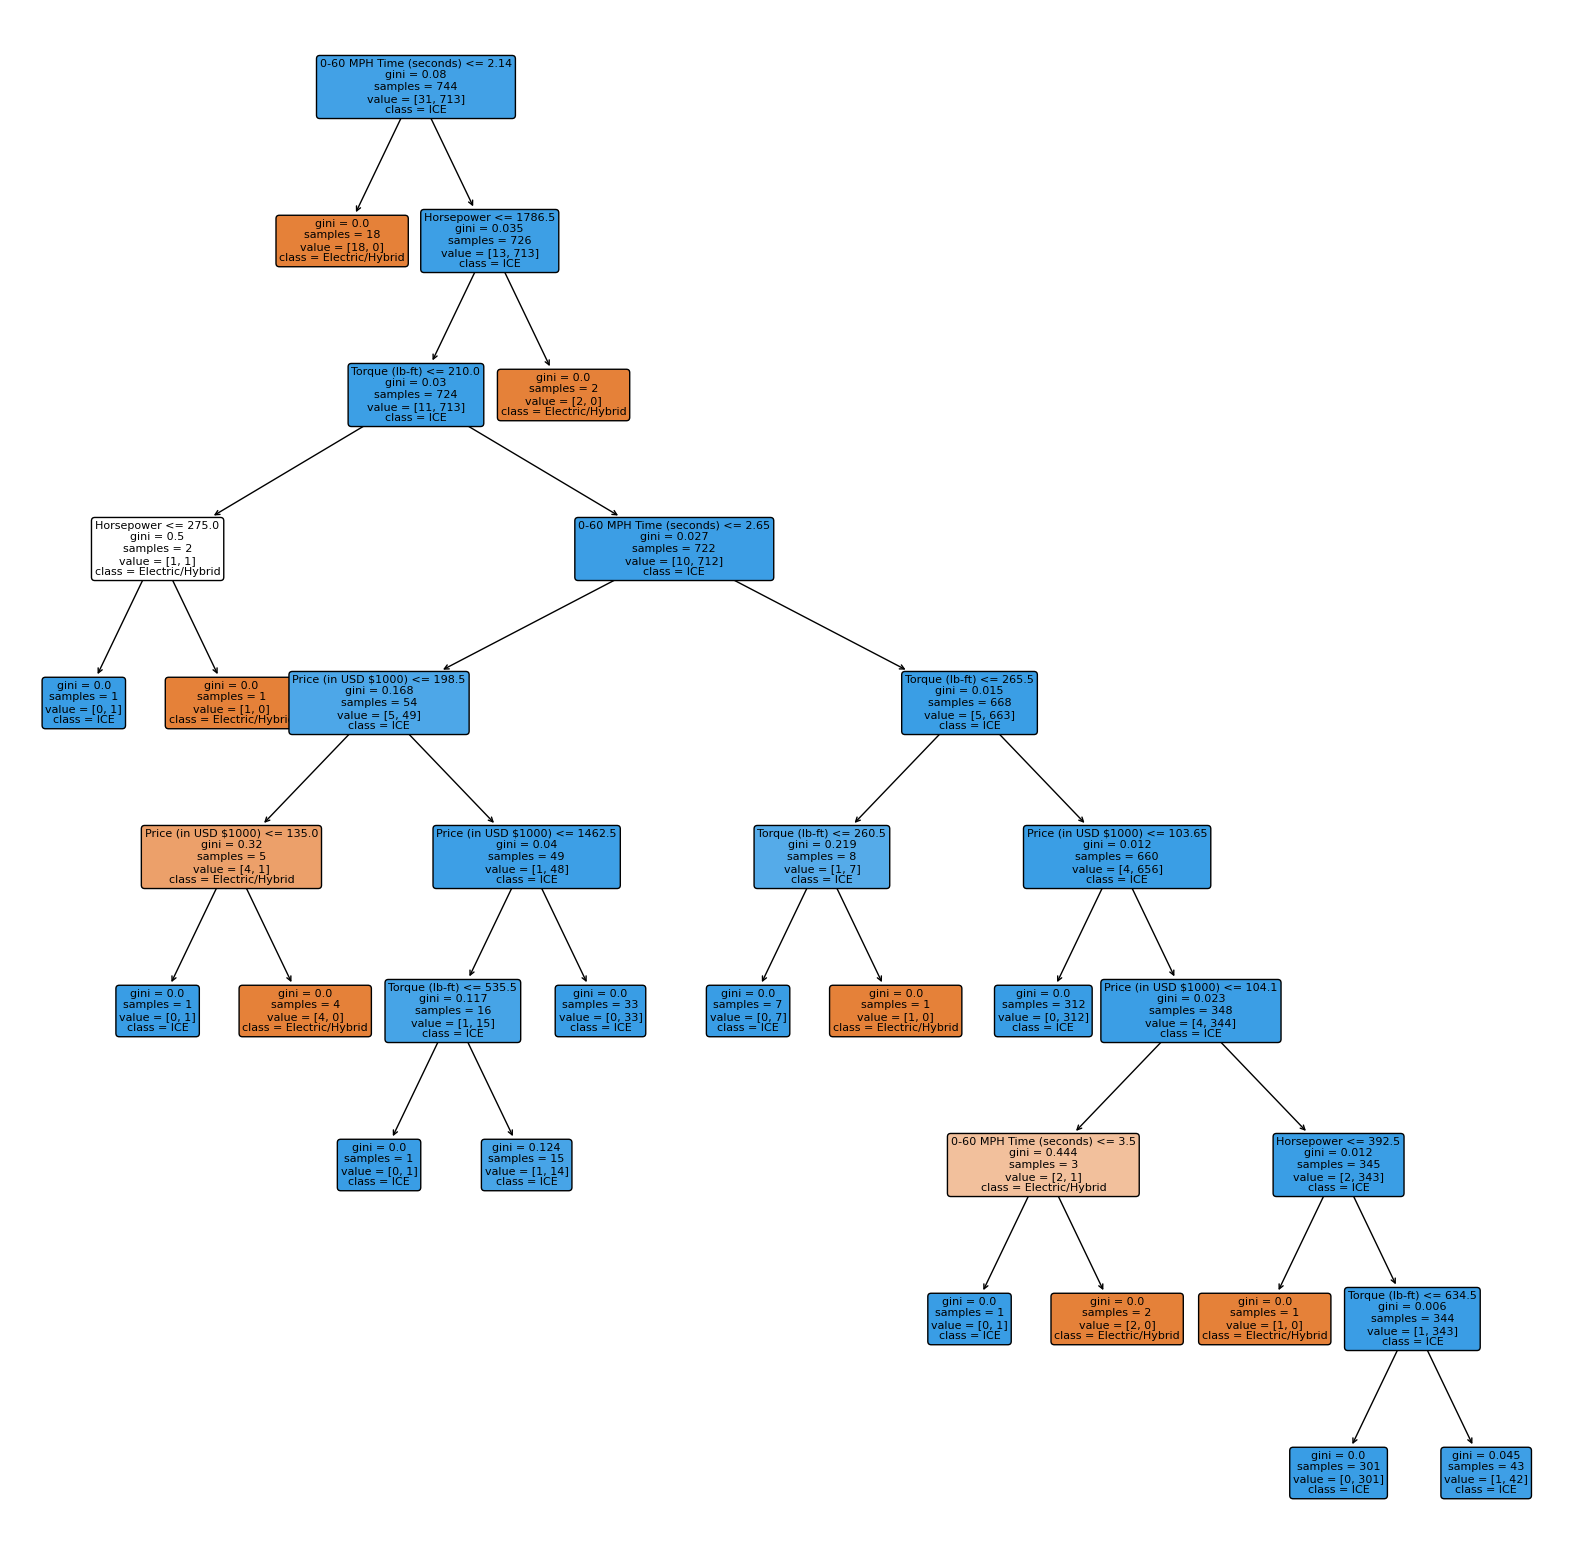

In [25]:
for i in range(len(gini_models)):
    plt.figure(figsize=(10+i*5, 10+i*5))
    tree.plot_tree(gini_models[i], filled=True, feature_names=model_gini.feature_names_in_, class_names=model_gini.classes_, fontsize=8, rounded=True)
    plt.show()

In [26]:
ent_models = []
print('Using the entropy-criterion:')
for i in [3, 6, 9]:
    model_ent = DecisionTreeClassifier(random_state=7, criterion='entropy', max_depth=i)
    model_ent.fit(X1_train, y1_train)
    print(f'For max depth of {i}, the training R2score was {round(model_ent.score(X1_train, y1_train),3)} and test R2 score was {round(model_ent.score(X1_test, y1_test),3)}')
    y_predict = model_ent.predict(X1_test)
    print(f'The accuracy for max depth of {i} was {round(accuracy_score(y1_test,y_predict),5)*100}%')
    ent_models.append(model_ent)

Using the entropy-criterion:
For max depth of 3, the training R2score was 0.988 and test R2 score was 0.984
The accuracy for max depth of 3 was 98.394%
For max depth of 6, the training R2score was 0.997 and test R2 score was 0.984
The accuracy for max depth of 6 was 98.394%
For max depth of 9, the training R2score was 0.999 and test R2 score was 0.976
The accuracy for max depth of 9 was 97.59%


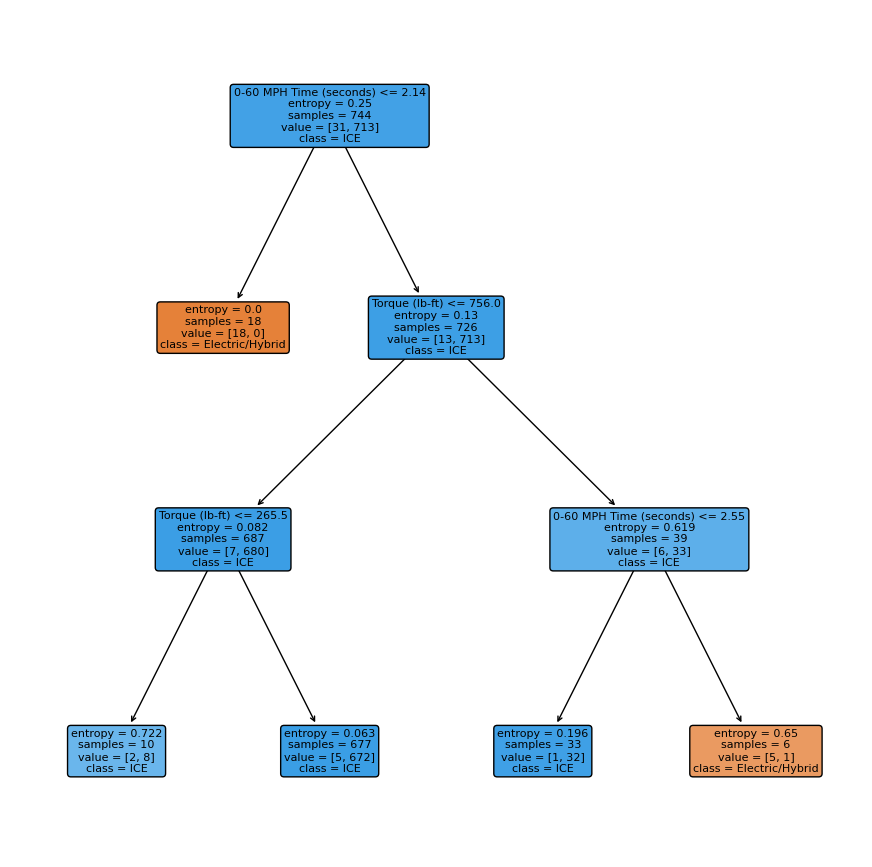

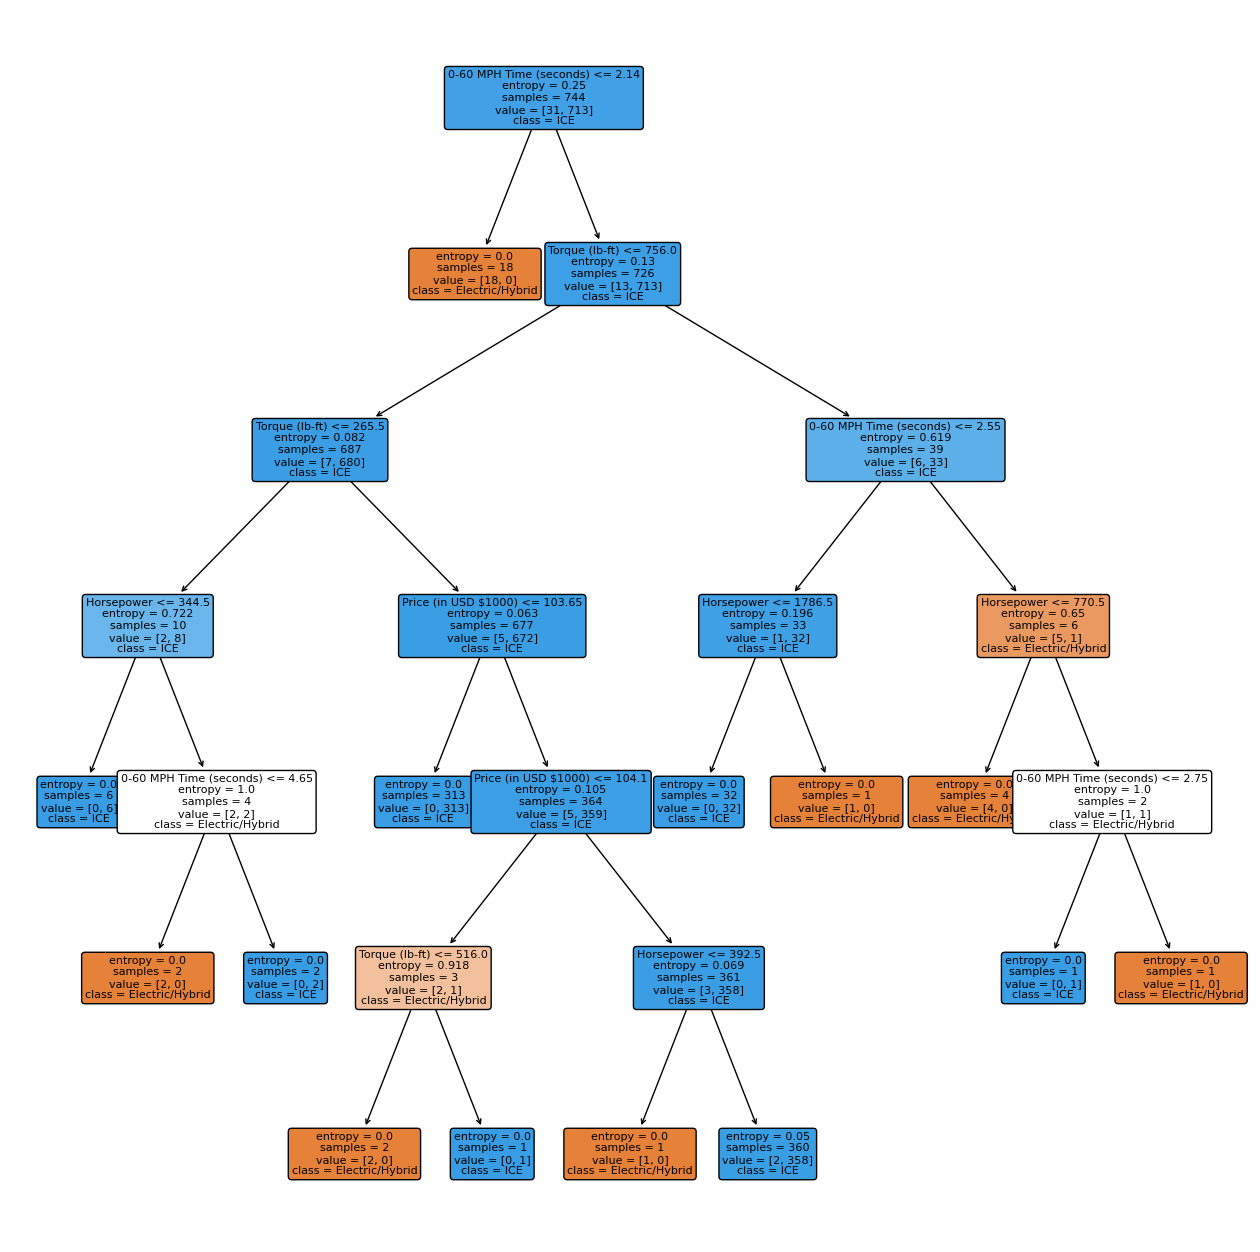

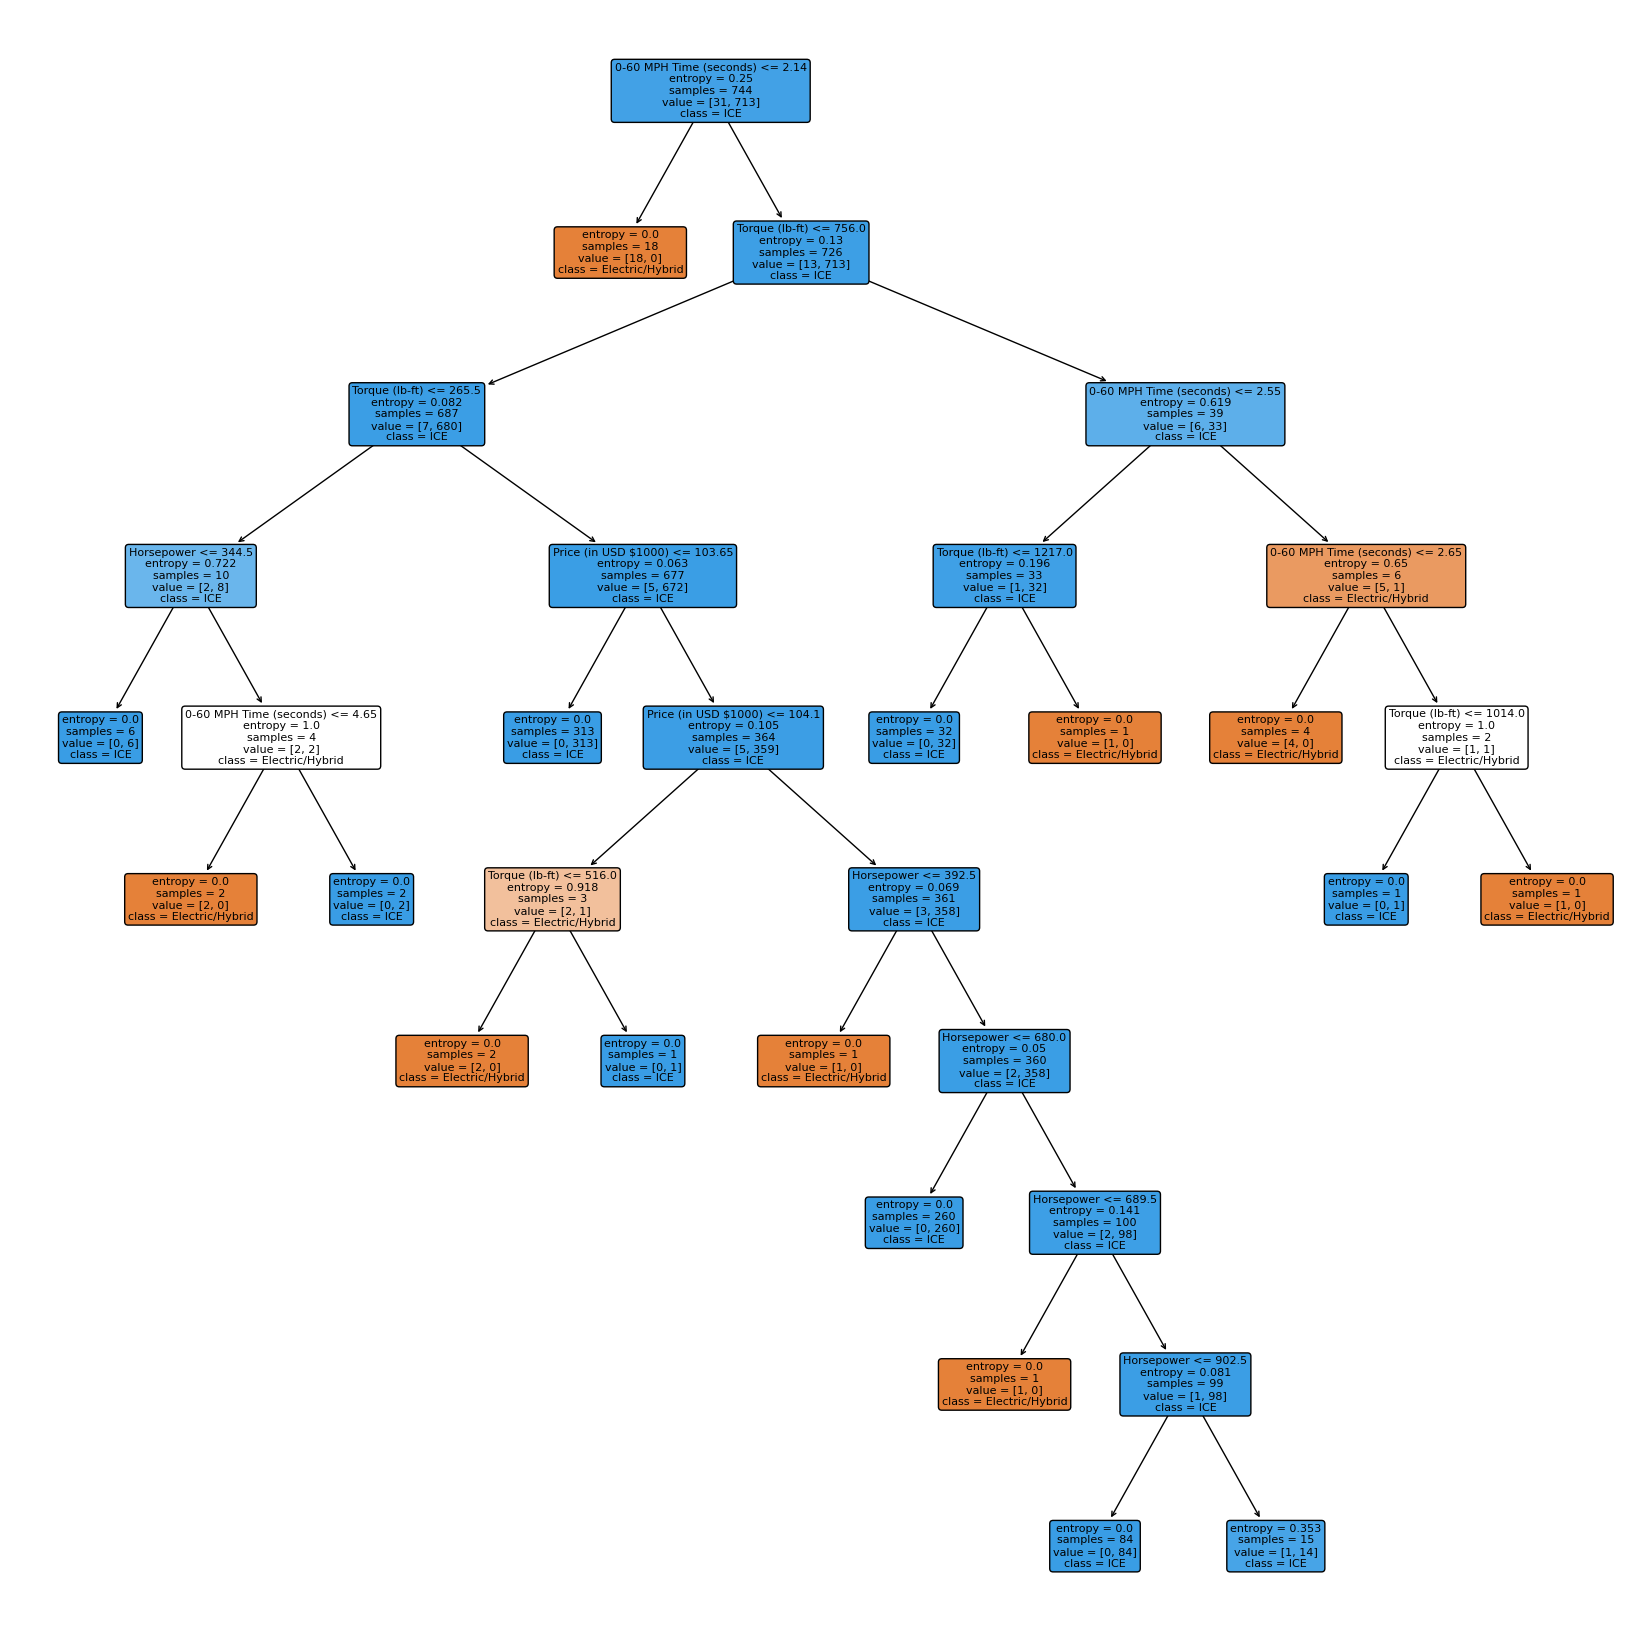

In [27]:
for i in range(len(ent_models)):
    plt.figure(figsize=(11+i*5, 11+i*5))
    tree.plot_tree(ent_models[i], filled=True, feature_names=model_ent.feature_names_in_, class_names=model_ent.classes_, fontsize=8, rounded=True)
    plt.show()